<a href="https://colab.research.google.com/github/RehamJamal13/model/blob/main/Topic_Modeling_with_tf_idf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Download pakages
#NATURAL LANGUAGE PROCESSING

#1. NLTK

#!pip install nltk
import nltk as nlp
#nltk.download()
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer

#2. SPACY
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.0.0/en_core_web_md-2.0.0.tar.gz
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
#!pip install <model_s3_url> # tar.gz file e.g. from release notes like https://github.com/explosion/spacy-models/releases//tag/en_core_web_lg-2.3.1
#!pip install en_core_web_lg
#3 scispacy
!pip install scispacy

#4 langdetect To detect the language of the text:
!pip install langdetect
#5
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz
#6 pyresparser
!pip install pyresparser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 KB 20.5 MB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Uninstalling wasabi-1.1.1:
      Successfully uninstalled wasabi-1.1.1
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.1
    Uninstalling spacy-3.5.1:
      Successfully uninstalled spacy-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.5.0 requ

In [ ]:
#@title Load Packages
import numpy as np
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import scispacy
import spacy
#import en_core_sci_lg

from scipy.spatial.distance import jensenshannon

import joblib

from IPython.display import HTML, display

import os
import glob
import json
import re
import string
import networkx as nx
import gc

from IPython.utils import io
#with io.capture_output() as captured:

 # !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

from pprint import pprint
from copy import deepcopy

from collections import  Counter

from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

from tqdm import tqdm
from os.path import isfile

import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [ ]:
#@title Load Data
df = pd.read_csv('/content/Bibliography_copy1.csv')

ParserError: ignored

In [ ]:
#@title Prepare Data
df.head()

In [ ]:
df.shape

(19186, 10)

In [ ]:
#Count NaN values under an entire DataFrame:
df.isna().sum().sum

In [ ]:
#Count NaN values under Title (TI) column :
df['Title'].isna().sum()

In [ ]:
df['Primary Title (T1)'].isna().sum()

In [ ]:
df['Secondary Title (T2)'].isna().sum()

In [ ]:
df['Short Title (ST)'].isna().sum()

In [ ]:
df['Tertiary Title (T3)'].isna().sum()

In [ ]:
df['Translated Author (TA)'].isna().sum()


In [ ]:
#Take the rows where Title (TI) is NA:
df = df[df['Title'].notna()]

In [ ]:
#Filtered out non-English titles with langdetect
from langdetect import detect
def detect_english(text):
   try:
    return detect(text) == 'en'
   except:
    return False

df = df[df['Title'].apply(detect_english)]

NameError: ignored

In [ ]:
#Remove Duplicate Rows Using DataFrame.apply() and Lambda Function
df2 = df.apply(lambda x: x.astype(str).str.lower()).drop_duplicates(subset=['Title'],keep='first')

In [ ]:
len(df['Title'].unique())

13314

In [ ]:
# change column name
df2.rename(columns = {'Title':'TITLE'}, inplace = True)
# consider the Title
new_data = df2.TITLE
#save data
df2.to_csv('/content/drive/MyDrive/Colab_Notebooks/Bibliography_EN.csv')

In [ ]:
df2['TITLE'].describe(include='all')

count                                                 13159
unique                                                13159
top       female genital cutting and infertility - nejm ...
freq                                                      1
Name: TITLE, dtype: object

In [ ]:
#@title preprocessing
#For preprocessing we use scispaCy, which is a Python package containing spaCy models for processing biomedical, scientific or clinical text.
#Use ScispaCy’s (a spaCy package) “en_core_sci_lg” model for biomedical, scientific, and clinical vocabulary to do parts of speech tagging
from spacy.lang.en.stop_words import STOP_WORDS
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure',
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.',
    'al.', 'Elsevier', 'PMC', 'CZI', 'www','99m','450','15'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)
stopwords = stopwords + ['mr', 'mrs', 'family','come', 'go', 'get', 'tell', 'listen', 'one', 'two', 'three', 'four',
                         'five', 'six', 'seven', 'eight', 'nine', 'zero', 'join', 'find', 'make', 'say',
                         'ask', 'tell', 'see', 'try', 'back', 'also','movie',
                         '1','2','3','4','5','6','7','8','9','10','0',
                         'film', 'movie', 'watch', 'cinema', 'scene','action', 'fighting','story', '3D'
                         'show', 'get','tell', 'listen']

In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
#!pip install en_core_web_lg
#import spacy
import en_core_web_lg
import en_core_web_lg
tagger = en_core_web_lg.load(disable=["parser", "ner"]) # review
tagger.max_length = 7000000
"""sentence = "[The epidemiology of malaria in Bursa--2009-2012]"
mytokens = parser(sentence)
txt=[]
for word in mytokens:
    txt.append(word.pos_)
print(txt)"""
def spacy_tokenizer(sentence,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    mytokens = tagger(sentence)
    mytokens = [ word for word in mytokens if word.text not in stopwords and word.text not in punctuations and word.pos_ in allowed_postags]
    mytokens = " ".join([str(i) for i in mytokens])
    return mytokens

tqdm.pandas()
df2["processed_title"] = df2["TITLE"].progress_apply(spacy_tokenizer)
#ADD document id column
df2['DOC_ID']=df.index
df2.to_csv('/content/drive/MyDrive/Colab_Notebooks/Bibliography_DOCID.csv')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


100%|██████████| 13159/13159 [00:58<00:00, 226.44it/s]


In [ ]:
#@title Vectorization
# TF-IF
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(analyzer='word',stop_words= stopwords, max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return vectorizer, X
#text = df['processed_title']
text = df2['processed_title'].values
vectorizer,X = vectorize(text, 2 ** 12)
X.shape

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3dshow', 'czi', 'elsevier', 'll', 'pmc', 've'] not in stop_words.
  warnings.warn(


(13159, 4096)

In [ ]:
#@title Doc2Vec
import gensim
from gensim.models import Doc2Vec

def doc2vec():
    document_tagged = []
    tagged_count = 0
    for _ in text:
        document_tagged.append(gensim.models.doc2vec.TaggedDocument(_,[tagged_count]))
        tagged_count +=1
    d2v = Doc2Vec(document_tagged)
    d2v.train(document_tagged,epochs=d2v.epochs,total_examples=d2v.corpus_count)
    return d2v.docvecs.vectors_docs

In [ ]:
%time doc2vec = doc2vec()
import seaborn as sns
plt.figure(figsize=(16,16))
sns.heatmap(doc2vec,cmap="coolwarm")

<Axes: ylabel='word'>

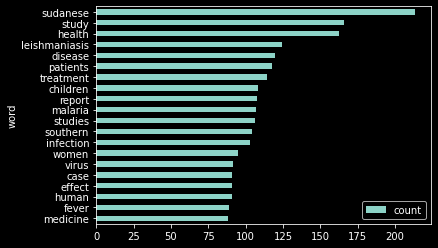

In [ ]:
# most frequent words(first 20)
from sklearn.feature_extraction.text import CountVectorizer

# show document feature vectors
vocabulary = vectorizer.get_feature_names_out()
# Creating the Bag of Words model
word_count = pd.DataFrame({'word': vocabulary, 'count': np.asarray(X.sum(axis=0))[0]})
word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')




In [ ]:
joblib.dump(vectorizer, 'vectorizer.csv')
joblib.dump(X , 'data_vectorized.csv')

['data_vectorized.csv']

In [ ]:
from sklearn.decomposition import PCA # review

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(13159, 2763)

In [ ]:
#@title PCA & Clustering
"""from sklearn.decomposition import PCA # review

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape"""
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
data = doc2vec
# run kmeans with many different k
distortions = []
K = range(2,45)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(data)
    k_means.fit(data)
    distortions.append(sum(np.min(cdist(data, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
"""from sklearn.decomposition import PCA # review

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape"""
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
data = doc2vec
sil = []
"""K = range(200,500,100)

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in k:
  kmeans = KMeans(n_clusters = k).fit(X_reduced)
  labels = kmeans.labels_
  sil.append(silhouette_score(X_reduced, labels, metric = 'euclidean'))
  distortions = []"""
K = range(2,45)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(data)
    k_means.fit(data)
    labels = k_means.labels_
    sil.append(silhouette_score(data, labels, metric = 'euclidean'))
    #print('Found distortion for {} clusters'.format(k))

X_line = [K[0], K[-1]]
Y_line = [sil[0], sil[-1]]

# Plot the silhouette_score
plt.plot(K, sil, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('sil')
plt.title('The silhouette_score Method showing the optimal k')
plt.show()

In [ ]:
#heirachical graph
import scipy.cluster.hierarchy as hier
plt.figure(figsize=(16,12))# Fit the heirachical graph
heirachical_graph=hier.dendrogram(hier.linkage(X_reduced, method='ward')) #method='ward' uses the Ward variance minimization algorithm# Add titles and labels
plt.title('Hierachical Clustering Graph')
plt.xlabel('Titles')
plt.ylabel('Euclidean Distance')

In [ ]:
# Davies Bouldin score for K means
from sklearn.metrics import davies_bouldin_score
data = doc2vec
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)# Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)

    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    return score

scores = []
centers = list(range(2,45))
for center in centers:
  scores.append(get_kmeans_score(data, center))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');

In [ ]:
data = doc2vec
print(data)

In [ ]:
# Run K_Means
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#data = doc2vec
X_reduced = scaler.fit_transform(X.toarray())
k = 40
#kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', max_iter=100, n_init=1)
#kmeans.fit(X_reduced)
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
#df2['y'] = y_pred
df2['TOPIC_ID'] = y_pred
df2.to_csv('/content/drive/MyDrive/Colab_Notebooks/Bibliography_DOCID.csv')

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
dists = cdist(X.toarray(),kmeans.cluster_centers_,metric='euclidean')
dists

array([[22.26187857, 95.41274519, 43.89059558, ..., 70.80143119,
        55.1811287 , 62.32880371],
       [22.23370254, 95.40617504, 43.87631105, ..., 70.79257694,
        55.16976759, 62.31874568],
       [22.23370254, 95.40617504, 43.87631105, ..., 70.79257694,
        55.16976759, 62.31874568],
       ...,
       [22.26523487, 95.41352834, 43.89229803, ..., 70.79284148,
        55.18248283, 62.33000255],
       [22.25969568, 95.4122359 , 43.88948843, ..., 70.80074486,
        55.18024809, 62.32802408],
       [22.25620598, 95.41250592, 43.89007543, ..., 70.80110875,
        55.18071498, 62.32843743]])

In [ ]:
#@title  KMeans Clustering Reinforced With Doc2Vec
data = doc2vec
# importing KMeans library of sklearn
from sklearn.cluster import KMeans

def kmeans(n_clusters):
    kmean_model = KMeans(n_clusters = n_clusters,random_state=0)
    return kmean_model

In [ ]:
kmeans.cluster_centers_

In [ ]:
kmeans.inertia_

11809.156609683667

In [ ]:
#Standard measures of cluster quality
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, kmeans.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, kmeans.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, kmeans.labels_, sample_size=1000))

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand-Index: 1.000
Silhouette Coefficient: 0.024


In [ ]:
y = df2['TITLE']
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df2['TITLE']= le.fit_transform(df2['TITLE'])
y = le.transform(y)

In [ ]:
labels = kmeans.labels_

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

Result: 0 out of 13159 samples were correctly labeled.


In [ ]:
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Accuracy score: 0.00


In [ ]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: rabbits cholesterol fed juice grapefruit heritable suppresses atheromatosis atherosclerosis atherosclerotic
Cluster 1: broth nutrient hydrophobic carriers derivatives self antimicrobial systems agents drugs
Cluster 2: pharmacokinetic considerations interaction chloride tannins dysfunction applications antibiotics men variations
Cluster 3: reptiles exotic respiration interesting intensive snakes collected rate imported upper
Cluster 4: design multi insecticide vector country impact resistance investigation control malaria
Cluster 5: hemolytic responsible newborn pro thalassemia disease sudanese starch arabica concentrated
Cluster 6: norms inequitable gender participatory influences attitudes approach based planning sex
Cluster 7: leishmaniasis visceral dermal cutaneous kala agglutination stibogluconate leishmania post direct
Cluster 8: analgesic antiinflammatory inflammatory sclerosis henna calotropis anti prescription nephropathy capillary
Cluster 9: sheep desert goats pharm

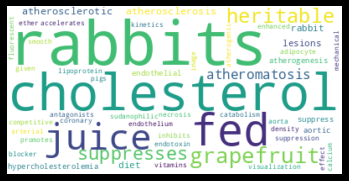

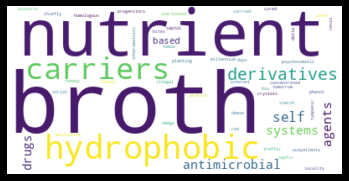

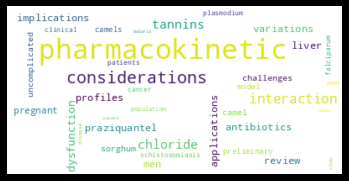

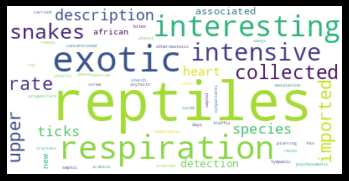

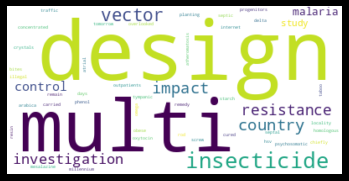

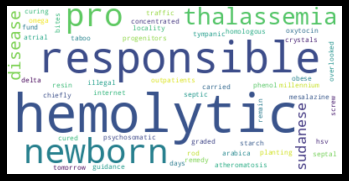

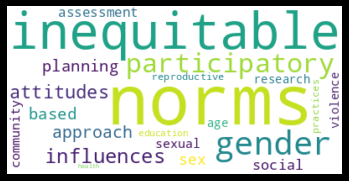

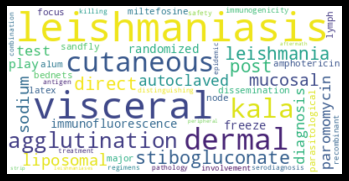

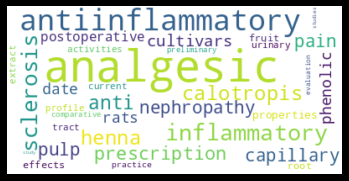

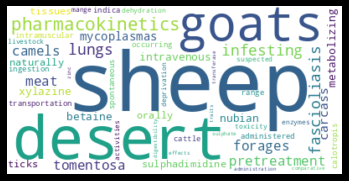

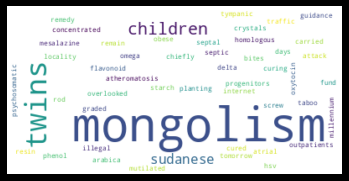

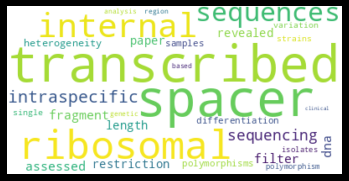

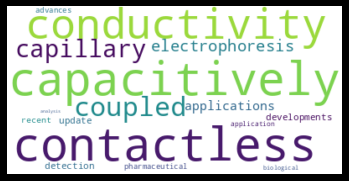

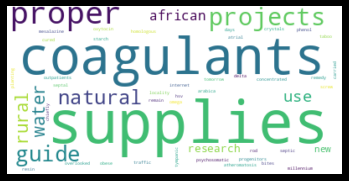

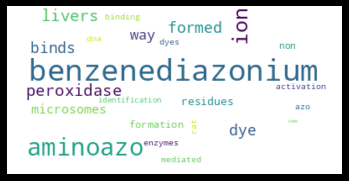

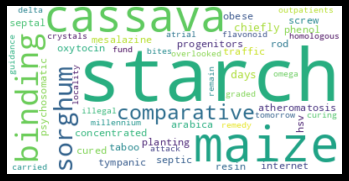

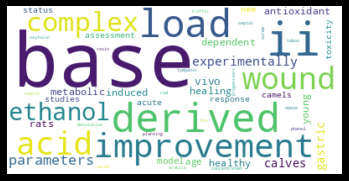

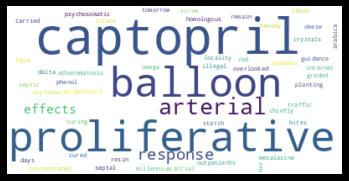

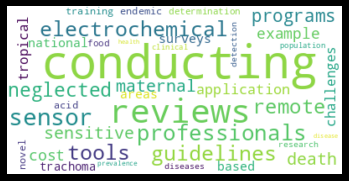

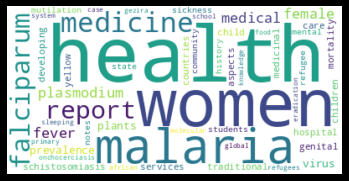

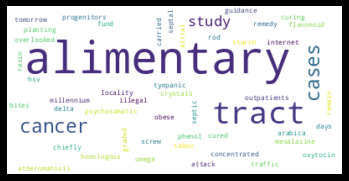

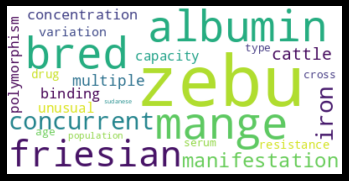

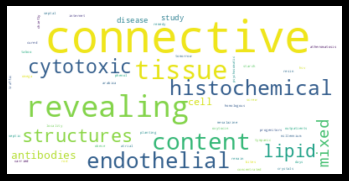

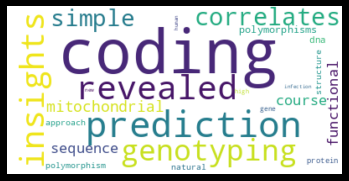

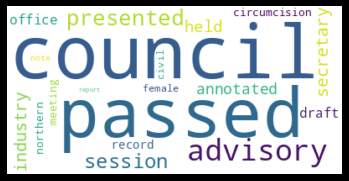

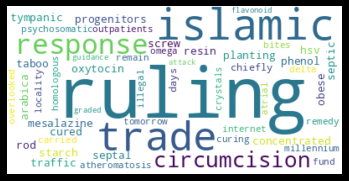

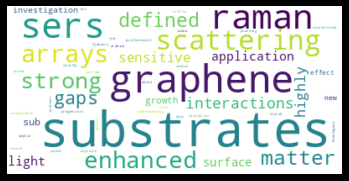

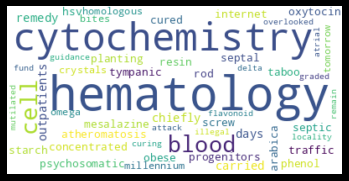

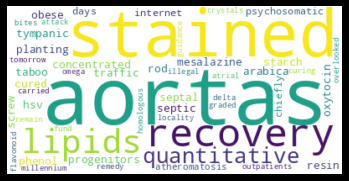

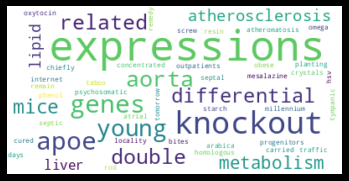

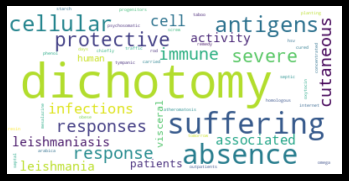

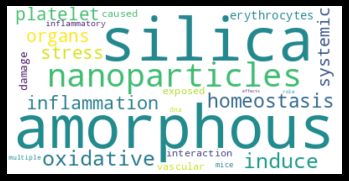

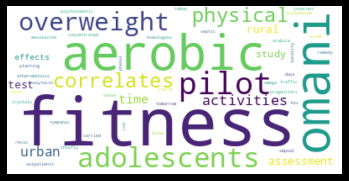

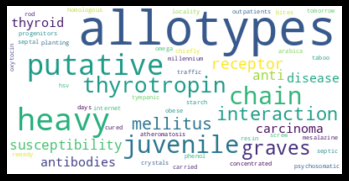

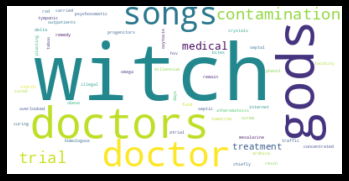

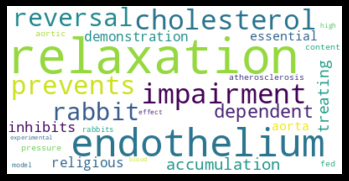

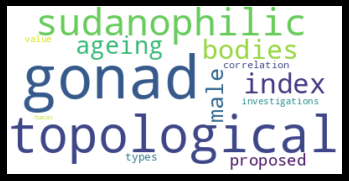

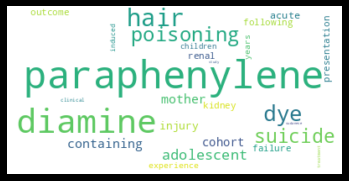

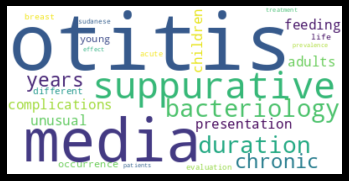

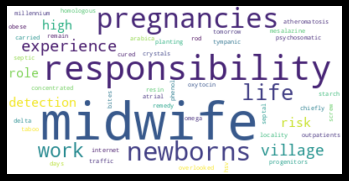

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def frequencies_dict(cluster_index):
    if cluster_index > k - 1:
        return
    term_frequencies = kmeans.cluster_centers_[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies
def makeImage(frequencies):

    wc = WordCloud(background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
for i in range(k):
    freq = frequencies_dict(i)
    makeImage(freq)
    print()

In [ ]:
#@title Dimensionality Reduction with t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(data)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 13271 samples in 0.003s...
[t-SNE] Computed neighbors for 13271 samples in 8.326s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13271
[t-SNE] Computed conditional probabilities for sample 2000 / 13271
[t-SNE] Computed conditional probabilities for sample 3000 / 13271
[t-SNE] Computed conditional probabilities for sample 4000 / 13271
[t-SNE] Computed conditional probabilities for sample 5000 / 13271
[t-SNE] Computed conditional probabilities for sample 6000 / 13271
[t-SNE] Computed conditional probabilities for sample 7000 / 13271
[t-SNE] Computed conditional probabilities for sample 8000 / 13271
[t-SNE] Computed conditional probabilities for sample 9000 / 13271
[t-SNE] Computed conditional probabilities for sample 10000 / 13271
[t-SNE] Computed conditional probabilities for sample 11000 / 13271
[t-SNE] Computed conditional probabilities for sample 12000 / 13271
[t-SNE] Computed conditional probabilities for sa

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


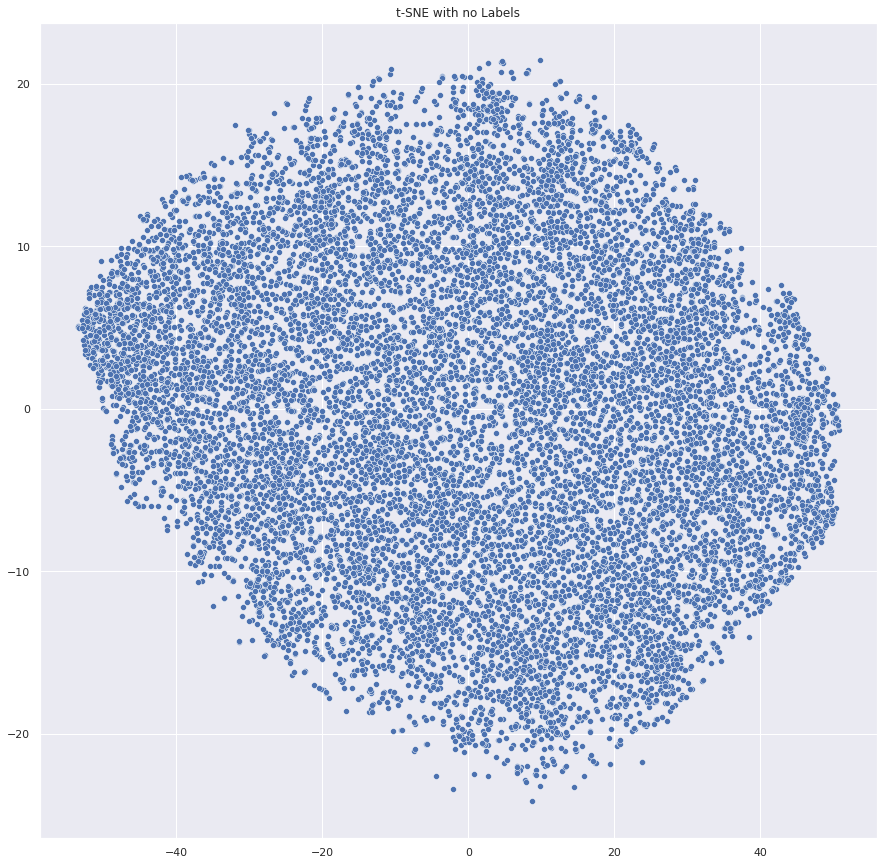

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_Title.png")
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


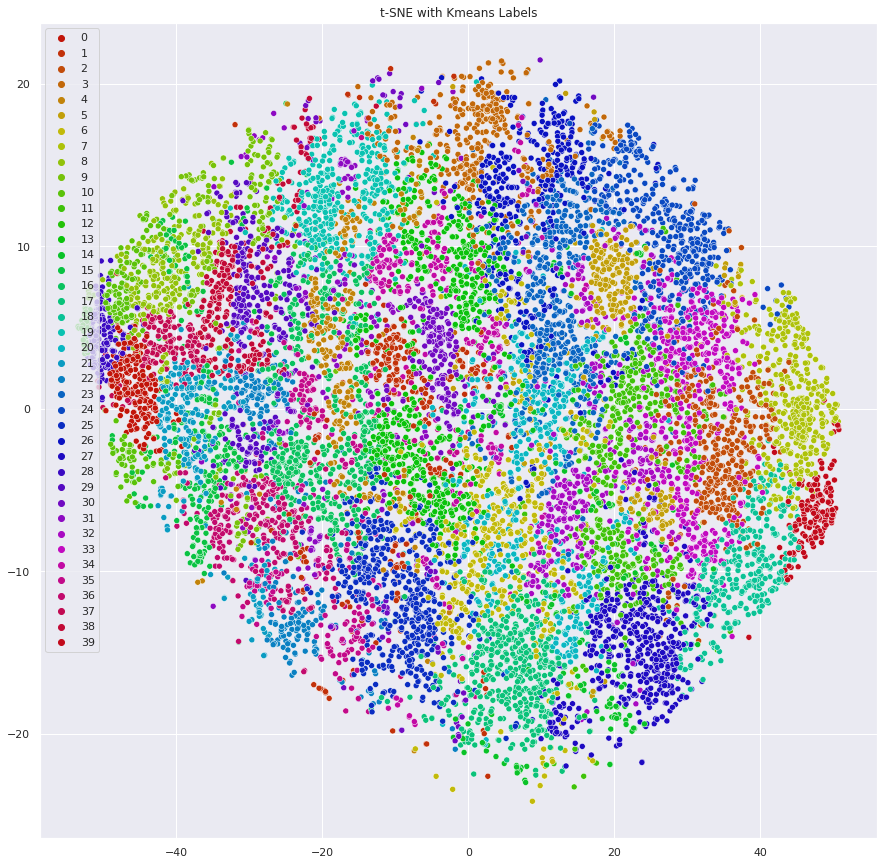

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(40, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()


In [ ]:
#@title Topic Modeling
# LDA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
"""lda = LatentDirichletAllocation(n_components=50, random_state=0)
lda.fit(data_vectorized)
joblib.dump(lda, 'lda.csv')"""

In [ ]:
vectorizers = []

for ii in range(0, 40):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words=stopwords, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

vectorizers[0]

In [ ]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_title']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)
    len(vectorized_data)

In [ ]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 42

lda_models = []
for ii in range(0, 42):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)

lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=42,
                          random_state=42, verbose=False)

In [ ]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))

    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [ ]:
clusters_lda_data

In [ ]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=42):
    current_words = []
    keywords = []

    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])

    keywords.sort(key = lambda x: x[1])
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values


In [ ]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
all_keywords[0][:10]

['immunity',
 'endemic',
 'treatment',
 'infection',
 'mansoni',
 'irrigation',
 'cattle',
 'evaluation',
 'study',
 'irrigated']

In [ ]:

len(all_keywords)

42

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
def plot_cloud(model,index):
  firstcloud = WordCloud(
                          stopwords=stopwords,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(selected_topics(model, vectorizer, top_n=42)))
  plt.imshow(firstcloud)
  plt.axis('off')
  plt.show()
for i in range (0,42):
  plot_cloud(lda_models[i],index = i)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


NotFittedError: ignored

In [ ]:
#@title Pyldavis-topic-modelling
#!pip install pyldavis
import pyLDAvis.sklearn
import pickle
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_models[0], vectorized_data[0], vectorizers[0], mds='tsne')
panel
#LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(90))
#LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
#LDAvis_prepared

#lda_models, vectorized_data, vectorizers


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has 

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
13    -155.352600  -49.317432       1        1  18.521286
6       22.682430  177.984283       2        1   9.137028
17     121.214493  -14.716586       3        1   8.136713
28     -80.057938 -126.920280       4        1   6.796777
40     136.442719  -95.486565       5        1   5.256192
32     159.517502  -60.028221       6        1   4.988231
3     -130.384262   84.755943       7        1   4.763532
12      68.599388  129.225037       8        1   4.310561
15      86.163544 -128.088181       9        1   3.359745
20      91.306046  -68.901718      10        1   2.850468
1      -86.352654  124.167587      11        1   2.624932
7      141.576233   93.395096      12        1   2.350848
33      27.702347 -115.805603      13        1   2.342486
2     -102.347595  -70.282890      14        1   2.287073
34    -154.920639   29.448778      15        1   2.098786
23     -35.172047  153.433838      16        1   1.938036
41     -24.586111 -129.804016      17        1   1.759463
39       5.211431  116.313248      18        1   1.751212
24      80.348518   80.100517      19        1   1.138219
35    -115.140152   -3.779499      20        1   1.111271
10     101.229897   35.053230      21        1   1.074542
36      30.544186  -63.416424      22        1   0.542981
37     -44.789608    9.261930      23        1   0.542981
38     -14.919358  -77.237778      24        1   0.542981
31      -8.320598   67.416054      25        1   0.542981
30      62.316910    5.110415      26        1   0.542981
29     -79.399261   23.942762      27        1   0.542981
0      -37.227253  -25.470171      28        1   0.542981
27     -75.979599   63.819199      29        1   0.542981
26     -12.814779   28.214779      30        1   0.542981
25      30.851410   78.984070      31        1   0.542981
22     -52.992165  -59.370914      32        1   0.542981
19      23.997675  -24.456390      33        1   0.542981
18      25.113203    9.729871      34        1   0.542981
16     -74.050301  -19.873301      35        1   0.542981
14      18.452957   43.065830      36        1   0.542981
11      -8.299350   -4.751708      37        1   0.542981
9      -39.743126   87.715744      38        1   0.542981
8       -5.863688  -42.191414      39        1   0.542981
5       54.447353   42.111252      40        1   0.542981
4      -42.133282   46.274647      41        1   0.542981
21      60.125240  -31.878048      42        1   0.542981, topic_info=         Term       Freq      Total Category  logprob  loglift
42      sudan  80.000000  80.000000  Default  30.0000  30.0000
1        area  20.000000  20.000000  Default  29.0000  29.0000
14     gezira  30.000000  30.000000  Default  28.0000  28.0000
8     control  18.000000  18.000000  Default  27.0000  27.0000
41      study  22.000000  22.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
27  mortality   0.065256  10.872034  Topic42  -3.9138   0.1002
8     control   0.072320  18.569025  Topic42  -3.8111  -0.3323
43   sudanese   0.068955  14.911860  Topic42  -3.8587  -0.1606
2     aspects   0.066007  13.070763  Topic42  -3.9024  -0.0725
34   patients   0.064705  18.313582  Topic42  -3.9223  -0.4297

[1706 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.592816    anglo
1         1  0.674276     area
1        15  0.192650     area
2         1  0.229520  aspects
2         6  0.535546  aspects
...     ...       ...      ...
48        3  0.147639      use
48       19  0.147639      use
48       20  0.295279      use
49        1  0.553754  workers
49        9  0.138439  workers

[124 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 7, 18, 29, 41, 33, 4, 13, 16, 21, 2, 8, 34, 3, 35, 24, 42, 40, 25, 36, 11, 37, 38, 39, 32, 31, 30, 1